In [1]:
# Import required packages
import matplotlib.pyplot as plt
import numpy as np

import pandas as pd

import datetime 
import matplotlib.dates as mdates

from sklearn.svm import SVR
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_absolute_percentage_error

In [2]:
from matplotlib import rcParams

plt.style.use('ggplot')
rcParams['figure.figsize'] = 12, 5
rcParams['pdf.fonttype'] = 3
rcParams['font.size'] = 8
rcParams['axes.linewidth'] = 1

In [3]:
df = pd.read_csv('./../data/weather_dataset_preprocesado.csv')
load = df['T (degC)']
time = df['datetime']

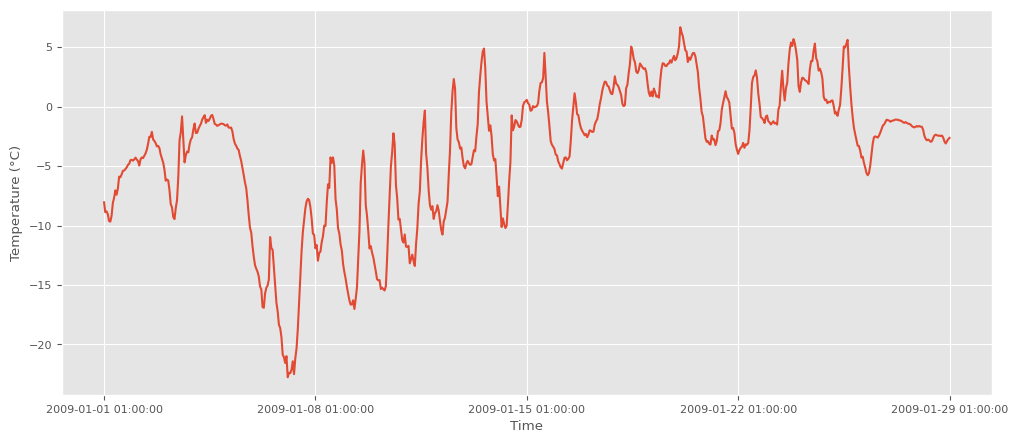

In [4]:
plt.plot(time[:673], load[:673])
plt.xticks(np.arange(0, 673, step = 168))
plt.xlabel('Time')
plt.ylabel('Temperature (°C)')
plt.show()

In [6]:
# #replace 0 value with the minimum value except 0
# second_min = min(load[load != 0])
# load[load == 0] = second_min
# display(load[load == 0])

C:\Users\sevann radhak\AppData\Local\Temp\ipykernel_5520\2982811346.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  load[load == 0] = second_min


Series([], Name: Usage_kWh, dtype: float64)

In [5]:
display(load.describe())

count    50224.000000
mean         9.254321
std          8.625312
min        -22.760000
25%          3.140000
50%          9.450000
75%         15.452500
max         35.650000
Name: T (degC), dtype: float64

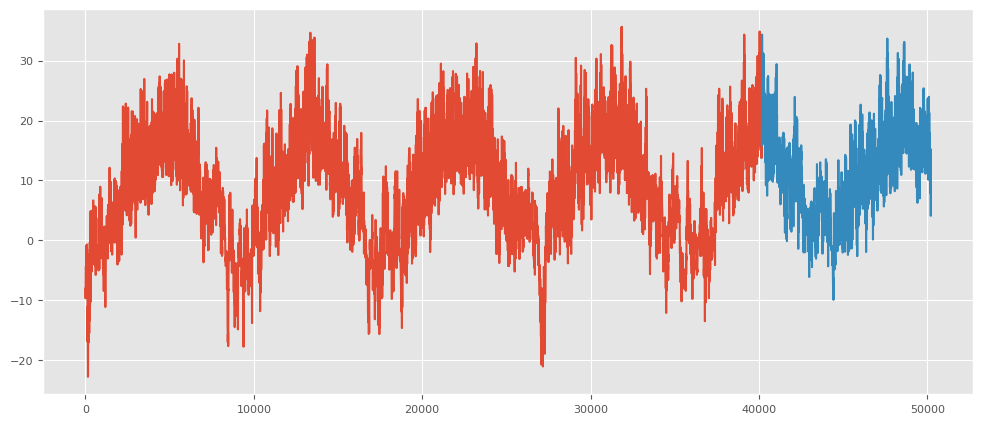

In [6]:
train = load[:int(len(load)*0.8)]
test = load[int(len(load)*0.8):]
plt.plot(train)
plt.plot(test)
plt.show()

<Figure size 1200x500 with 0 Axes>

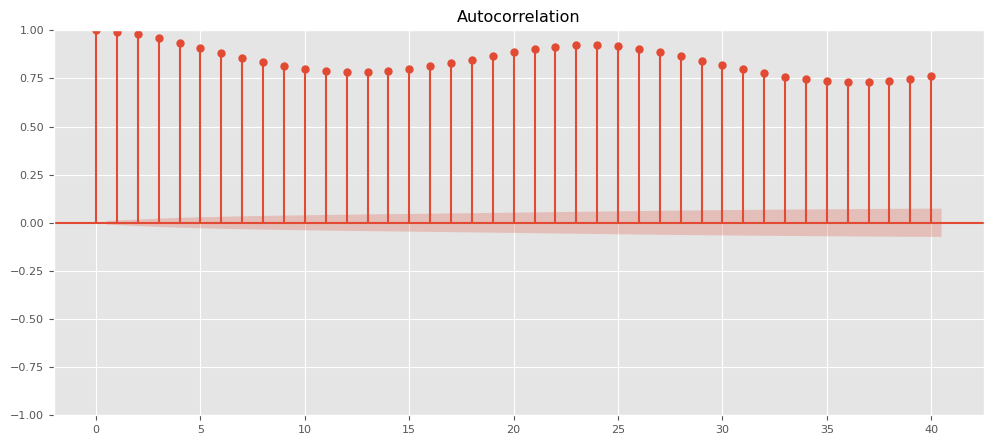

<Figure size 1200x500 with 0 Axes>

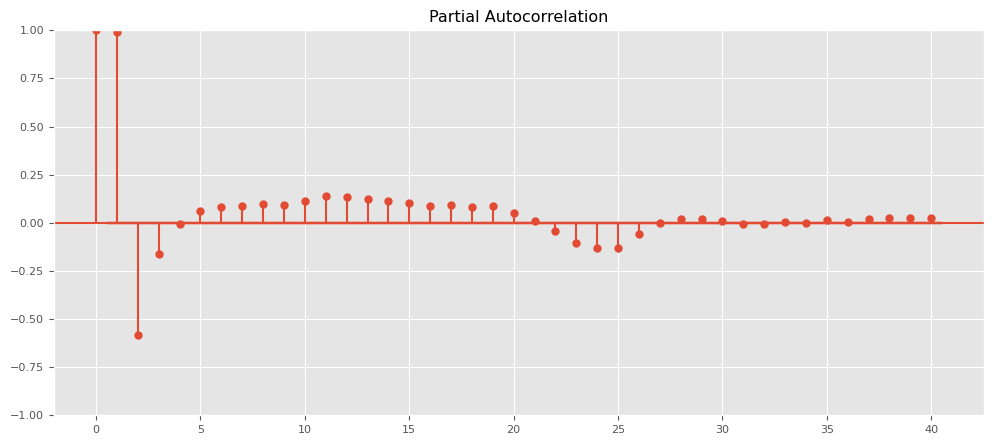

In [7]:
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

plt.figure()
acf_values = acf(train)
plot_acf(train, lags=40)
plt.show()

plt.figure()
pacf_values = pacf(train)
plot_pacf(train, lags=40)
plt.show()

In [8]:
df_train = pd.DataFrame(train)
df_test = pd.DataFrame(test)
t_degc = 'T (degC)'

for i in range(1,4):
    df_train["lag{}".format(i)] = df_train[t_degc].shift(i)
    df_test["lag{}".format(i)] = df_test[t_degc].shift(i)

df_train = df_train.bfill()
df_train = df_train.drop(columns = [t_degc])
df_test = df_test.bfill()
df_test = df_test.drop(columns = [t_degc])

display(df_train, df_test)

,lag1,lag2,lag3
0,-8.05,-8.05,-8.05
1,-8.05,-8.05,-8.05
2,-8.88,-8.05,-8.05
3,-8.81,-8.88,-8.05
4,-9.05,-8.81,-8.88
...,...,...,...
40174,22.40,23.72,26.45
40175,20.36,22.40,23.72
40176,19.28,20.36,22.40
40177,18.88,19.28,20.36


,lag1,lag2,lag3
40179,15.89,15.89,15.89
40180,15.89,15.89,15.89
40181,16.37,15.89,15.89
40182,18.50,16.37,15.89
40183,21.14,18.50,16.37
...,...,...,...
50219,13.17,10.36,8.01
50220,13.69,13.17,10.36
50221,14.19,13.69,13.17
50222,14.99,14.19,13.69


# Empirical M Decomposition - SVM¶

In [9]:
!pip install emd

# EEMD

<Axes: xlabel='Time (samples)'>

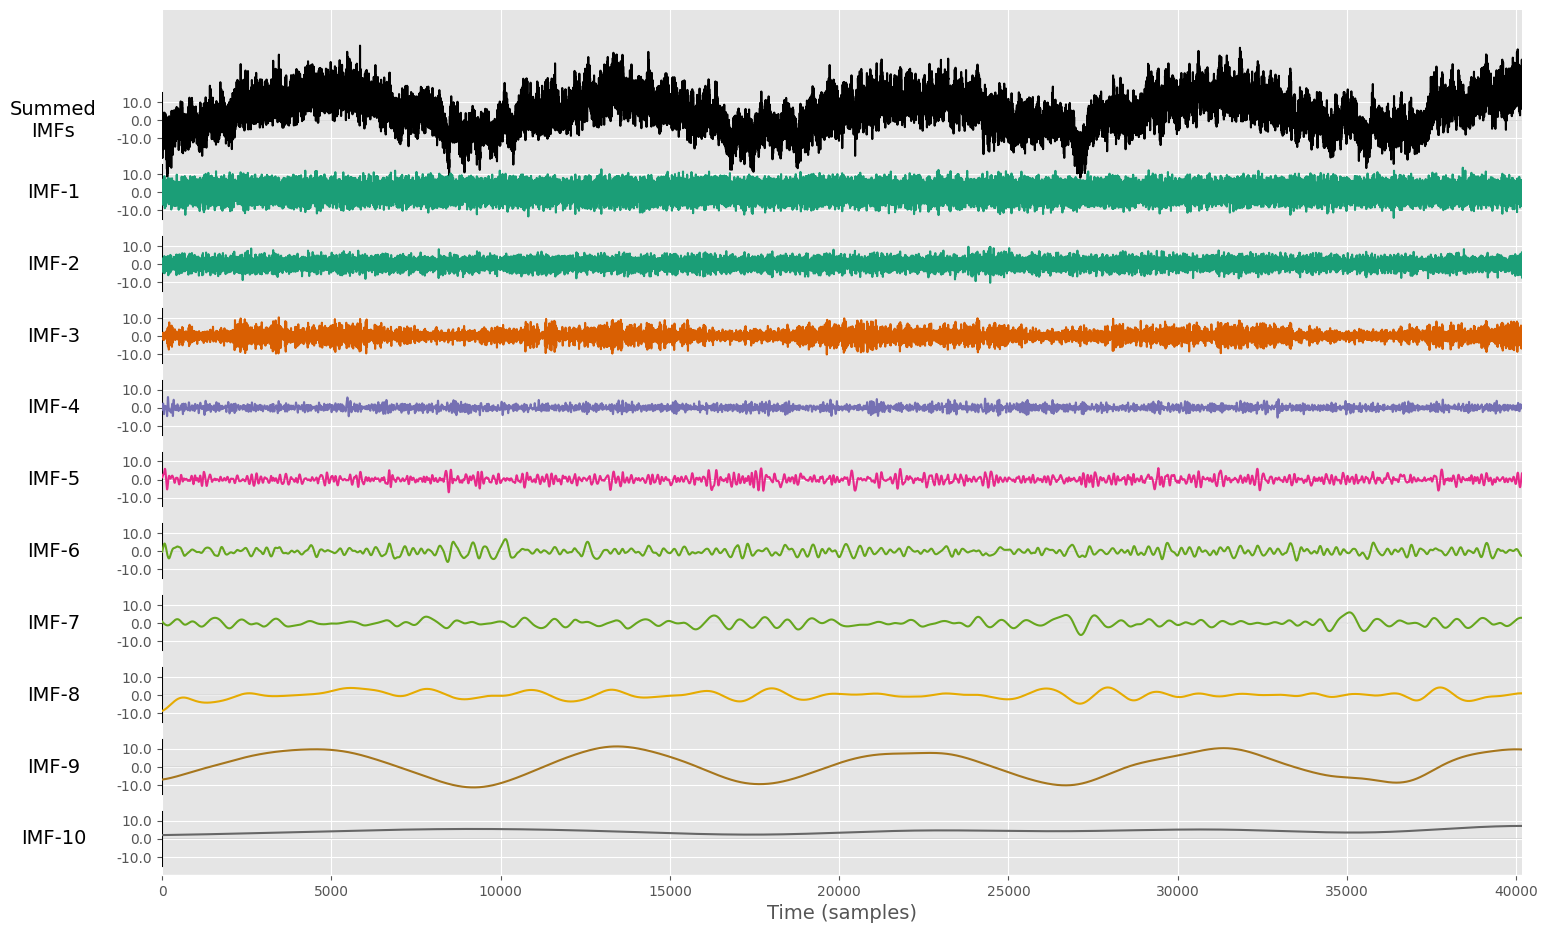

In [10]:
import emd

imf_eemd = emd.sift.ensemble_sift(np.array(train), nensembles=4, nprocesses=6, ensemble_noise=1, imf_opts={'sd_thresh': 0.1})
emd.plotting.plot_imfs(imf_eemd)

In [11]:
imf_eemd_df = pd.DataFrame(data = imf_eemd)
imf_eemd_df.columns = ['imf_eemd_{}'.format(i+1) for i in range(0, imf_eemd.shape[1])]
display(imf_eemd_df)

,imf_eemd_1,imf_eemd_2,imf_eemd_3,imf_eemd_4,imf_eemd_5,imf_eemd_6,imf_eemd_7,imf_eemd_8,imf_eemd_9,imf_eemd_10
0,4.767375,-2.001427,1.300109,-1.014414,1.179025,-0.212768,0.858993,-8.784880,-7.033864,1.972819
1,3.501545,-1.099567,1.239471,-1.074834,1.180871,-0.128715,0.835543,-8.777266,-7.031219,1.973115
2,2.936037,0.410307,1.154979,-1.099581,1.193394,-0.043784,0.812189,-8.769582,-7.028567,1.973410
3,-3.424364,2.016813,1.040486,-1.089230,1.216207,0.041949,0.788933,-8.761826,-7.025906,1.973706
4,0.159531,2.740680,0.860767,-1.044476,1.248812,0.128411,0.765774,-8.754001,-7.023237,1.974002
...,...,...,...,...,...,...,...,...,...,...
40174,1.526433,-7.618960,-4.577981,1.298048,3.487645,-2.495442,2.961740,0.939698,9.563344,7.033535
40175,3.028449,-6.141972,-5.195132,1.296321,3.467698,-2.490777,2.959447,0.939353,9.562221,7.033575
40176,6.785655,-4.000391,-5.236106,1.311586,3.432898,-2.485361,2.957064,0.938991,9.561090,7.033615
40177,-1.218017,-2.996612,-4.719933,1.340369,3.383611,-2.479192,2.954593,0.938611,9.559954,7.033653


In [12]:
imf1_eemd_SVR = SVR(kernel = 'rbf', C= 10, gamma= 0.01)
imf1_eemd_SVR.fit(df_train.values, imf_eemd_df['imf_eemd_1'])
imf1_eemd_SVR_fc = imf1_eemd_SVR.predict(np.array(df_test))

imf2_eemd_SVR = SVR(kernel = 'rbf', C= 10, gamma= 0.01)
imf2_eemd_SVR.fit(df_train.values, imf_eemd_df['imf_eemd_2'])
imf2_eemd_SVR_fc = imf2_eemd_SVR.predict(np.array(df_test))

imf3_eemd_SVR = SVR(kernel = 'rbf', C= 10, gamma= 0.01)
imf3_eemd_SVR.fit(df_train.values, imf_eemd_df['imf_eemd_3'])
imf3_eemd_SVR_fc = imf3_eemd_SVR.predict(np.array(df_test))

imf4_eemd_SVR = SVR(kernel = 'rbf', C= 10, gamma= 0.01)
imf4_eemd_SVR.fit(df_train.values, imf_eemd_df['imf_eemd_4'])
imf4_eemd_SVR_fc = imf4_eemd_SVR.predict(np.array(df_test))

imf5_eemd_SVR = SVR(kernel = 'rbf', C= 10, gamma= 0.01)
imf5_eemd_SVR.fit(df_train.values, imf_eemd_df['imf_eemd_5'])
imf5_eemd_SVR_fc = imf5_eemd_SVR.predict(np.array(df_test))

imf6_eemd_SVR = SVR(kernel = 'rbf', C= 10, gamma= 0.01)
imf6_eemd_SVR.fit(df_train.values, imf_eemd_df['imf_eemd_6'])
imf6_eemd_SVR_fc = imf6_eemd_SVR.predict(np.array(df_test))

imf7_eemd_SVR = SVR(kernel = 'rbf', C= 10, gamma= 0.01)
imf7_eemd_SVR.fit(df_train.values, imf_eemd_df['imf_eemd_7'])
imf7_eemd_SVR_fc = imf7_eemd_SVR.predict(np.array(df_test))

imf8_eemd_SVR = SVR(kernel = 'rbf', C= 10, gamma= 0.01)
imf8_eemd_SVR.fit(df_train.values, imf_eemd_df['imf_eemd_8'])
imf8_eemd_SVR_fc = imf8_eemd_SVR.predict(np.array(df_test))

imf9_eemd_SVR = SVR(kernel = 'rbf', C= 10, gamma= 0.01)
imf9_eemd_SVR.fit(df_train.values, imf_eemd_df['imf_eemd_9'])
imf9_eemd_SVR_fc = imf9_eemd_SVR.predict(np.array(df_test))

imf10_eemd_SVR = SVR(kernel = 'rbf', C= 10, gamma= 0.01)
imf10_eemd_SVR.fit(df_train.values, imf_eemd_df['imf_eemd_10'])
imf10_eemd_SVR_fc = imf10_eemd_SVR.predict(np.array(df_test))

# imf11_eemd_SVR = SVR(kernel = 'rbf', C= 10, gamma= 0.01)
# imf11_eemd_SVR.fit(df_train.values, imf_eemd_df['imf_eemd_11'])
# imf11_eemd_SVR_fc = imf11_eemd_SVR.predict(np.array(df_test))

In [14]:
imf_eemd_list = ['imf{}_eemd_SVR_fc'.format(i) for i in range(1,11)]

imf_eemd_fc = np.sum([imf1_eemd_SVR_fc, imf2_eemd_SVR_fc, imf3_eemd_SVR_fc,
                imf4_eemd_SVR_fc, imf5_eemd_SVR_fc,imf6_eemd_SVR_fc,
                imf7_eemd_SVR_fc,imf8_eemd_SVR_fc,imf9_eemd_SVR_fc, imf10_eemd_SVR_fc], axis = 0)

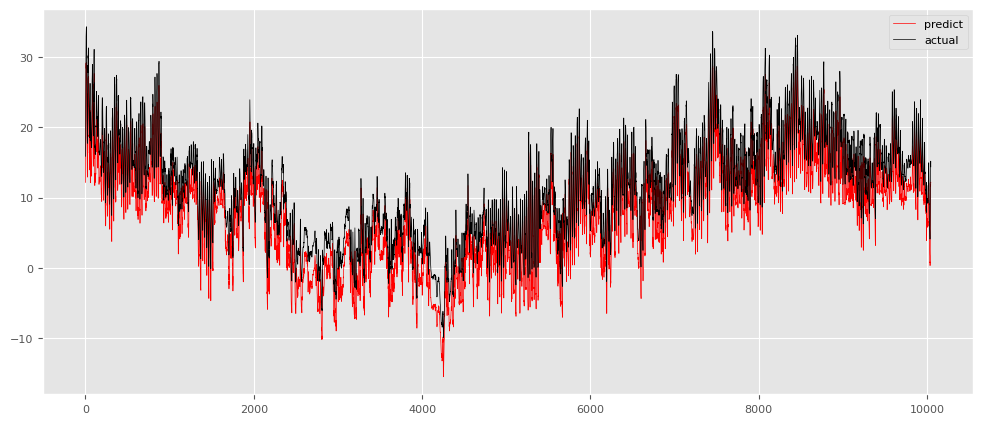

RMSE = 13.793298039587047 
MAE = 3.584236343725224 
MAPE = 3546980569578.792


In [16]:
plt.plot(imf_eemd_fc,label = 'predict', color = 'r', linewidth = 0.5)
plt.plot(test.values, label = 'actual', color = 'k', linewidth = 0.5)
plt.legend()
plt.savefig('EEMDSVR')
plt.show()

RMSE_EEMD_SVR = mean_squared_error(test, imf_eemd_fc)
MAE_EEMD_SVR  =mean_absolute_error(test, imf_eemd_fc)
MAPE_EEMD_SVR = mean_absolute_percentage_error(test, imf_eemd_fc)
print('RMSE = {}'.format(RMSE_EEMD_SVR), '\nMAE = {}'.format(MAE_EEMD_SVR), '\nMAPE = {}'.format(MAPE_EEMD_SVR))

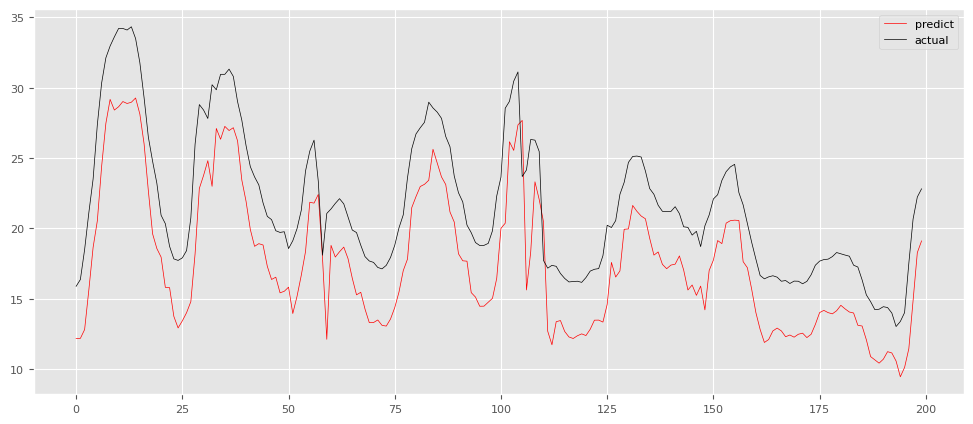

MSE = 13.793298039587047 
MAE = 3.584236343725224 
MAPE = 3546980569578.792


In [17]:
plt.plot(imf_eemd_fc[:200], label = 'predict', color = 'r', linewidth = 0.5)
plt.plot(test[:200].values, label = 'actual', color = 'k', linewidth = 0.5)
plt.legend()
plt.savefig('EEMDSVR_200')
plt.show()

RMSE_EEMD_SVR = mean_squared_error(test, imf_eemd_fc)
MAE_EEMD_SVR  =mean_absolute_error(test, imf_eemd_fc)
MAPE_EEMD_SVR = mean_absolute_percentage_error(test, imf_eemd_fc)
print('MSE = {}'.format(RMSE_EEMD_SVR), '\nMAE = {}'.format(MAE_EEMD_SVR), '\nMAPE = {}'.format(MAPE_EEMD_SVR))

In [18]:
imf1_eemd_SVR_fc = imf1_eemd_SVR.predict(np.array(df_train))
imf2_eemd_SVR_fc = imf2_eemd_SVR.predict(np.array(df_train))
imf3_eemd_SVR_fc = imf3_eemd_SVR.predict(np.array(df_train))
imf4_eemd_SVR_fc = imf4_eemd_SVR.predict(np.array(df_train))
imf5_eemd_SVR_fc = imf5_eemd_SVR.predict(np.array(df_train))
imf6_eemd_SVR_fc = imf6_eemd_SVR.predict(np.array(df_train))
imf7_eemd_SVR_fc = imf7_eemd_SVR.predict(np.array(df_train))
imf8_eemd_SVR_fc = imf8_eemd_SVR.predict(np.array(df_train))
imf9_eemd_SVR_fc = imf9_eemd_SVR.predict(np.array(df_train))
imf10_eemd_SVR_fc = imf10_eemd_SVR.predict(np.array(df_train))
# imf11_eemd_SVR_fc = imf11_eemd_SVR.predict(np.array(df_train))

imf_eemd_fc_train = np.sum([imf1_eemd_SVR_fc, imf2_eemd_SVR_fc, imf3_eemd_SVR_fc,
                imf4_eemd_SVR_fc, imf5_eemd_SVR_fc,imf6_eemd_SVR_fc,
                imf7_eemd_SVR_fc,imf8_eemd_SVR_fc,imf9_eemd_SVR_fc, imf10_eemd_SVR_fc], axis = 0)

In [19]:
from scipy.optimize import minimize

def dummy1(c):
    global train
    global imf_eemd_fc_train
    return mean_squared_error(train, imf_eemd_fc_train + c)

res1 = minimize(dummy1, 0, method='nelder-mead',
               options={'xatol': 1e-8, 'disp': True})
print(res1.x)

Optimization terminated successfully.
         Current function value: 0.961426
         Iterations: 42
         Function evaluations: 84
[3.67864035]


In [20]:
RMSE_EEMD_SVR = mean_squared_error(test, imf_eemd_fc + res1.x[0])
MAE_EEMD_SVR  =mean_absolute_error(test, imf_eemd_fc + res1.x[0])
MAPE_EEMD_SVR = mean_absolute_percentage_error(test, imf_eemd_fc + res1.x[0])
print('RMSE = {}'.format(RMSE_EEMD_SVR), '\nMAE = {}'.format(MAE_EEMD_SVR), '\nMAPE = {}'.format(MAPE_EEMD_SVR))

RMSE = 1.0156641362367251 
MAE = 0.7543651686562018 
MAPE = 248399522085.52136


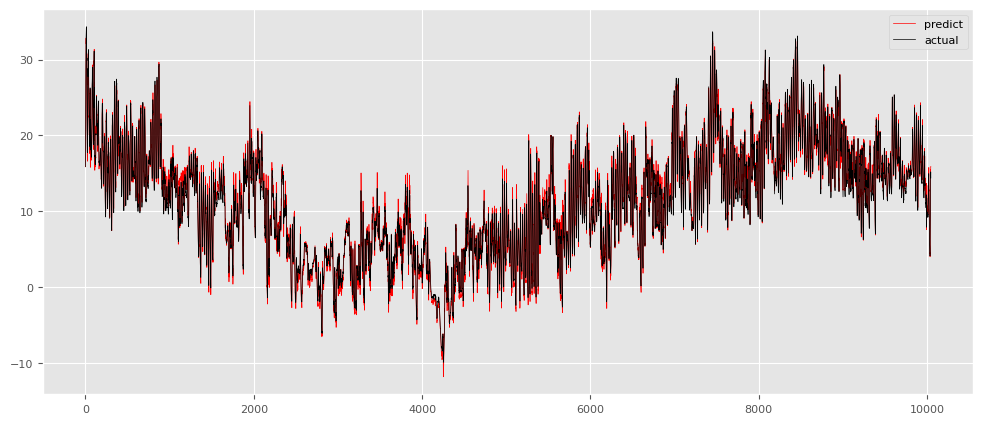

In [22]:
plt.plot(imf_eemd_fc + res1.x[0], label = 'predict', color = 'r', linewidth = 0.5)
plt.plot(test.values, label = 'actual', color = 'k', linewidth = 0.5)
plt.legend()
plt.savefig('ImprovedEEMDSVR')
plt.show()

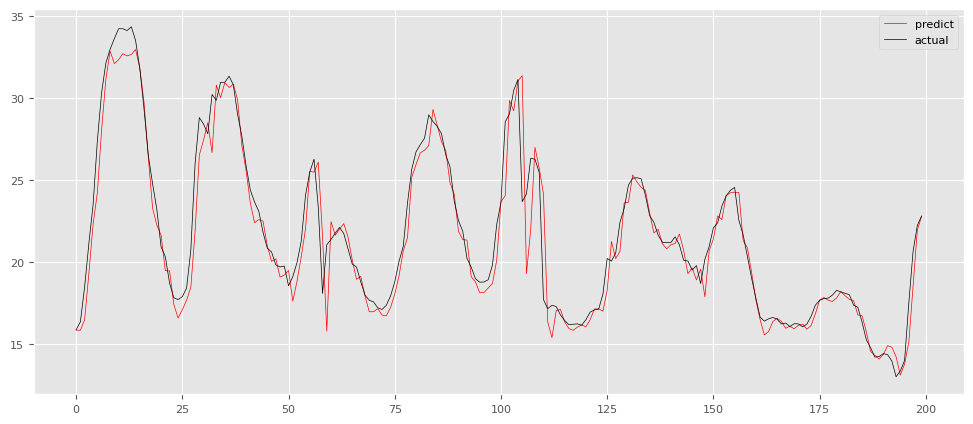

In [23]:
plt.plot(imf_eemd_fc[:200] + res1.x[0], label = 'predict', color = 'r', linewidth = 0.5)
plt.plot(test.values[:200], label = 'actual', color = 'k', linewidth = 0.5)
plt.legend()
plt.savefig('ImprovedEEMDSVR_200')
plt.show()

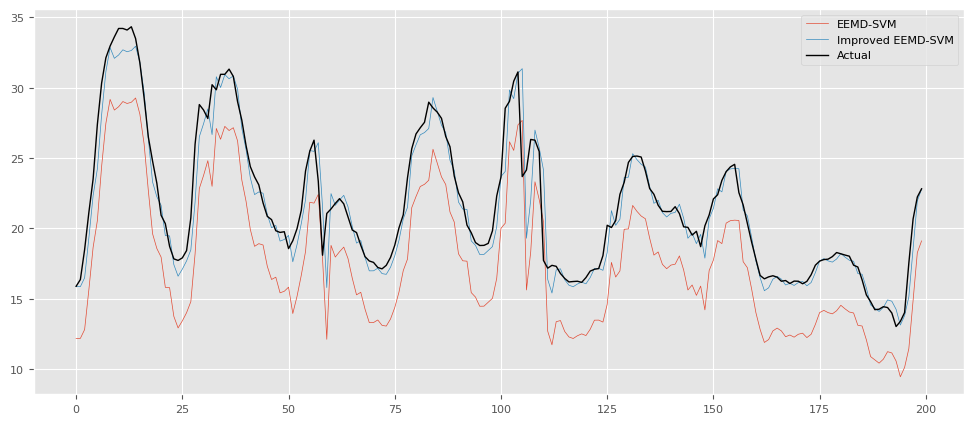

In [26]:
# plt.plot(arima_fc.values[:200], label = 'ARIMA')
# plt.plot(arima_SVR_fc[:200]+arima_fc.values[:200], label = 'ARIMA-SVM')
# plt.plot(hw_fc.values[:200], label = 'HW')
# plt.plot(hw_SVR_fc[:200]+hw_fc.values[:200], label = 'HW-SVM')
# plt.plot(SVR_fc[:200], label = 'SVM')
# plt.plot(SVR_MA_3_fc[0:200], label = 'SMA-SVM')
# plt.plot(imf_fc[:200], label = 'EMD-SVM')
# plt.plot(imf_fc[:200] + res.x[0], label = 'Improved EMD-SVM')
plt.plot(imf_eemd_fc[:200], label = 'EEMD-SVM', linewidth = 0.5)
plt.plot(imf_eemd_fc[:200] + res1.x[0], label = 'Improved EEMD-SVM', linewidth = 0.5)
plt.plot(test.values[:200], label = 'Actual', color = 'k', linewidth = 1) 
plt.legend()
plt.savefig('Summary')
plt.show()